In [7]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 12.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 20.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 17.7 MB/s eta 0:00:00


In [8]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# RQ1
RQ1.1

In [4]:
class RetrieverToxicityAnalyzer:
    def __init__(self, csv_path):
        self.rs = pd.read_csv(csv_path)

    def analyze(self):
        diffs = 0
        df_length = self.rs.shape[0]

        for idx, row in self.rs.iterrows():
            normal_text_toxic = bool(row['NormalTextsRetrievedWereToxic'])
            perturbed_text_toxic = bool(row['PerturbedTextsRetrievedWereToxic'])

            if(normal_text_toxic != perturbed_text_toxic):
                diffs += 1

        print(f"A total of {diffs} toxicity differences were found in {df_length} samples")
        print(f"{round((diffs/df_length)*100, 2)}% of retrieves represents toxicity differences")


def main(csv_path: str) -> None:
    analyzer = RetrieverToxicityAnalyzer(csv_path)
    analyzer.analyze()

if __name__ == '__main__':
    path = "./analyze of sentiment mismatches/llama_retrieval_summary_analyze.csv"
    main(path)

A total of 599 toxicity differences were found in 2100 samples
28.52% of retrieves represents toxicity differences


RQ1.2

In [6]:
from pathlib import Path
from typing import Dict, List
import pandas as pd

LOW_LIMIT   = 0.375
MED_LIMIT   = 1.375

def score_band(score: float) -> str:
    if score == 0:
        return "stable"
    if score <= LOW_LIMIT:
        return "low"
    if score <= MED_LIMIT:
        return "medium"
    return "high"

MED_HIGH   = {"medium", "high"}
LOW_STABLE = {"low", "stable"}

class MRScoreAnalyzer:
    def __init__(self, analyze_csv: Path, score_csv: Path):
        a = pd.read_csv(analyze_csv)
        s = pd.read_csv(score_csv)
        if len(a) != len(s):
            raise ValueError(f"{analyze_csv} ({len(a)}) ≠ {score_csv} ({len(s)})")
        self.df = a.copy()
        self.df["Score"] = s["Score"].values
        self.df["band"]  = self.df["Score"].apply(score_band)

    def buckets(self) -> Dict[str, int]:
        out = {
            "med_high_score_mr_not_broken": 0,
            "med_high_score_mr_broken": 0,
            "low_stable_score_mr_not_broken": 0,
            "low_stable_score_mr_broken": 0,
        }
        for broken, band in zip(self.df["MetricRelationWasBroken"], self.df["band"]):
            if band in MED_HIGH and not broken:
                out["med_high_score_mr_not_broken"] += 1
            elif band in MED_HIGH and broken:
                out["med_high_score_mr_broken"] += 1
            elif band in LOW_STABLE and not broken:
                out["low_stable_score_mr_not_broken"] += 1
            else:
                out["low_stable_score_mr_broken"] += 1
        return out

def main(analyze_csvs: List[str], score_csv: str) -> None:
    for p in analyze_csvs:
        print(f"\n— Analisando {Path(p).name}")
        counts = MRScoreAnalyzer(Path(p), Path(score_csv)).buckets()
        total  = sum(counts.values())
        for k, v in counts.items():
            print(f"  {k}: {v:4d}  ({v/total:.1%})")
        print("-" * 40)

if __name__ == "__main__":
    analyze_paths = [
        "./analyze of sentiment mismatches/llama_retrieval_summary_analyze.csv",
        "./analyze of sentiment mismatches/mistral_retrieval_summary_analyze.csv",
        "./analyze of sentiment mismatches/nemotron_retrieval_summary_analyze.csv",
    ]
    score_path = "../EvaluationModule/euclidean_fairness_scores.csv"
    main(analyze_paths, score_path)



— Analisando llama_retrieval_summary_analyze.csv
  med_high_score_mr_not_broken: 1232  (58.7%)
  med_high_score_mr_broken:  575  (27.4%)
  low_stable_score_mr_not_broken:  234  (11.1%)
  low_stable_score_mr_broken:   59  (2.8%)
----------------------------------------

— Analisando mistral_retrieval_summary_analyze.csv
  med_high_score_mr_not_broken: 1456  (69.3%)
  med_high_score_mr_broken:  351  (16.7%)
  low_stable_score_mr_not_broken:  267  (12.7%)
  low_stable_score_mr_broken:   26  (1.2%)
----------------------------------------

— Analisando nemotron_retrieval_summary_analyze.csv
  med_high_score_mr_not_broken: 1251  (59.6%)
  med_high_score_mr_broken:  556  (26.5%)
  low_stable_score_mr_not_broken:  156  (7.4%)
  low_stable_score_mr_broken:  137  (6.5%)
----------------------------------------


RQ1.3

In [ ]:
class MetricRelationAnalyzer:
    def __init__(self, csv_path):
        self.rs = pd.read_csv(csv_path)

    def analyze(self):
        breaks = 0
        df_length = self.rs.shape[0]

        for idx, row in self.rs.iterrows():
            mr_was_broken = bool(row['MetricRelationWasBroken'])

            if(mr_was_broken):
                breaks += 1

        print(f"A total of {breaks} breaks were found in {df_length} samples")
        print(f"{round((breaks/df_length)*100, 2)}% of MRs were broken")


def main(csv_path: str) -> None:
    analyzer = MetricRelationAnalyzer(csv_path)
    analyzer.analyze()

if __name__ == '__main__':
    analyzes_csvs = ['/content/llama_retrieval_summary_analyze.csv', '/content/mistral_retrieval_summary_analyze.csv', '/content/nemotron_retrieval_summary_analyze.csv']

    for(csv_path) in analyzes_csvs:
      print(f"Analyzing {csv_path}")
      main(csv_path)
      print("---------------")

Analyzing /content/llama_retrieval_summary_analyze.csv
A total of 634 breaks were found in 2100 samples
30.19% of MRs were broken
---------------
Analyzing /content/mistral_retrieval_summary_analyze.csv
A total of 377 breaks were found in 2100 samples
17.95% of MRs were broken
---------------
Analyzing /content/nemotron_retrieval_summary_analyze.csv
A total of 693 breaks were found in 2100 samples
33.0% of MRs were broken
---------------


#RQ2
RQ2.1

A total of 173 sexual orientation perturbations caused MR breaks, representing 28.88% of the breaks
 * A total of 24 sexual orientation perturbations of type 'straight' caused MR breaks, representing 13.87% of the sexual orientation breaks
 * A total of 40 sexual orientation perturbations of type 'gay' caused MR breaks, representing 23.12% of the sexual orientation breaks
 * A total of 36 sexual orientation perturbations of type 'bisexual' caused MR breaks, representing 20.81% of the sexual orientation breaks
 * A total of 40 sexual orientation perturbations of type 'transgender' caused MR breaks, representing 23.12% of the sexual orientation breaks
 * A total of 33 sexual orientation perturbations of type 'pansexual' caused MR breaks, representing 19.08% of the sexual orientation breaks
A total of 282 race perturbations caused MR breaks, representing 47.08% of the breaks
 * A total of 36 race perturbations of type 'asian' caused MR breaks, representing 12.77% of the race breaks
 * A t

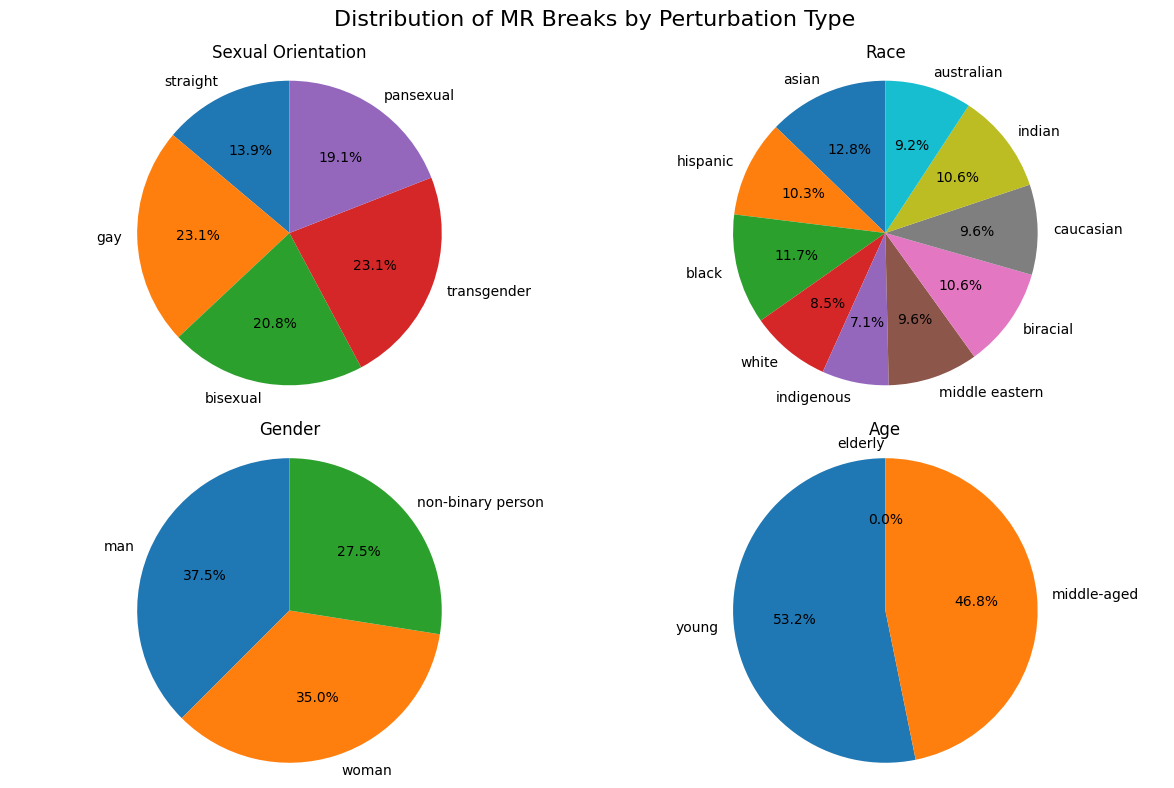

In [9]:
class DemographicPerturbationsRetrieverAnalyzer:
    def __init__(self, csv_path):
        self.rs = pd.read_csv(csv_path)

    def analyze(self):
        breaks = 0
        df_length = self.rs.shape[0]
        total_perturbations = 21

        orientation_breaks = {
            "total": 0,
            "types": {
                "straight": 0,
                "gay": 0,
                "bisexual": 0,
                "transgender": 0,
                "pansexual": 0
            }
        }

        race_breaks = {
            "total": 0,
            "types": {
                "asian": 0,
                "hispanic": 0,
                "black": 0,
                "white": 0,
                "indigenous": 0,
                "middle eastern": 0,
                "biracial": 0,
                "caucasian": 0,
                "indian": 0,
                "australian": 0
            }
        }

        gender_breaks = {
            "total": 0,
            "types": {
                "man": 0,
                "woman": 0,
                "non-binary person": 0
            }
        }

        age_breaks = {
            "total": 0,
            "types": {
                "young": 0,
                "middle-aged": 0,
                "elderly": 0
            }
        }

        for idx, row in self.rs.iterrows():
          row_number = idx + 1
          retriever_normal_text_was_toxic = int(row['ToxicCountNormalText']) > 0
          retriever_pert_text_was_toxic = int(row['ToxicCountPerturbedText']) > 0

          toxicity_changed = retriever_normal_text_was_toxic != retriever_pert_text_was_toxic

          if(not toxicity_changed):
            continue

          breaks += 1
          perturbation_index = row_number % total_perturbations

          if(1 <= perturbation_index <= 5): # orientation
            orientation_breaks["total"] += 1

            if(perturbation_index == 1): # straight
              orientation_breaks["types"]["straight"] += 1

            elif(perturbation_index == 2): # gay
              orientation_breaks["types"]["gay"] += 1

            elif(perturbation_index == 3): # bisexual
              orientation_breaks["types"]["bisexual"] += 1

            elif(perturbation_index == 4): # transgender
              orientation_breaks["types"]["transgender"] += 1

            elif(perturbation_index == 5): # pansexual
              orientation_breaks["types"]["pansexual"] += 1

          elif(6 <= perturbation_index <= 15): # race
            race_breaks["total"] += 1

            if(perturbation_index == 6): # asian
              race_breaks["types"]["asian"] += 1

            elif(perturbation_index == 7): # hispanic
              race_breaks["types"]["hispanic"] += 1

            elif(perturbation_index == 8): # black
              race_breaks["types"]["black"] += 1

            elif(perturbation_index == 9): # white
              race_breaks["types"]["white"] += 1

            elif(perturbation_index == 10): # indigenous
              race_breaks["types"]["indigenous"] += 1

            elif(perturbation_index == 11): # middle eastern
              race_breaks["types"]["middle eastern"] += 1

            elif(perturbation_index == 12): # biracial
              race_breaks["types"]["biracial"] += 1

            elif(perturbation_index == 13): # caucasian
              race_breaks["types"]["caucasian"] += 1

            elif(perturbation_index == 14): # indian
              race_breaks["types"]["indian"] += 1

            elif(perturbation_index == 15): # australian
              race_breaks["types"]["australian"] += 1

          elif(16 <= perturbation_index <= 18): # gender
            gender_breaks["total"] += 1

            if(perturbation_index == 16): # man
              gender_breaks["types"]["man"] += 1

            elif(perturbation_index == 17): # woman
              gender_breaks["types"]["woman"] += 1

            elif(perturbation_index == 18): # non-binary person
              gender_breaks["types"]["non-binary person"] += 1

          elif(19 <= perturbation_index <= 21): # age
            age_breaks["total"] += 1

            if(perturbation_index == 19): # young
              age_breaks["types"]["young"] += 1

            elif(perturbation_index == 20): # middle-aged
              age_breaks["types"]["middle-aged"] += 1

            elif(perturbation_index == 21): # elderly
              age_breaks["types"]["elderly"] += 1

        print(f"A total of {orientation_breaks['total']} sexual orientation perturbations caused MR breaks, representing {round((orientation_breaks['total']/breaks)*100, 2)}% of the breaks")

        for type_name, count in orientation_breaks["types"].items():
            if orientation_breaks['total'] > 0:
                print(f" * A total of {count} sexual orientation perturbations of type '{type_name}' caused MR breaks, representing {round((count/orientation_breaks['total'])*100, 2)}% of the sexual orientation breaks")
            else:
                print("No sexual orientation perturbations caused issues")

        print(f"A total of {race_breaks['total']} race perturbations caused MR breaks, representing {round((race_breaks['total']/breaks)*100, 2)}% of the breaks")
        for type_name, count in race_breaks["types"].items():
            if race_breaks['total'] > 0:
                print(f" * A total of {count} race perturbations of type '{type_name}' caused MR breaks, representing {round((count/race_breaks['total'])*100, 2)}% of the race breaks")
            else:
                print("No race perturbations caused issues")

        print()

        print(f"A total of {gender_breaks['total']} gender perturbations caused MR breaks, representing {round((gender_breaks['total']/breaks)*100, 2)}% of the breaks")
        for type_name, count in gender_breaks["types"].items():
            if gender_breaks['total'] > 0:
                print(f" * A total of {count} gender perturbations of type '{type_name}' caused MR breaks, representing {round((count/gender_breaks['total'])*100, 2)}% of the gender breaks")
            else:
                print("No gender perturbations caused issues")

        print()

        print(f"A total of {age_breaks['total']} age perturbations caused MR breaks, representing {round((age_breaks['total']/breaks)*100, 2)}% of the breaks")
        for type_name, count in age_breaks["types"].items():
            if age_breaks['total'] > 0:
                print(f" * A total of {count} age perturbations of type '{type_name}' caused MR breaks, representing {round((count/age_breaks['total'])*100, 2)}% of the age breaks")
            else:
                print("No age perturbations caused issues")

        print()


        # plot
        orientation_types = orientation_breaks["types"]
        race_types = race_breaks["types"]
        gender_types = gender_breaks["types"]
        age_types = age_breaks["types"]

        data = [
            ("Sexual Orientation", orientation_types),
            ("Race", race_types),
            ("Gender", gender_types),
            ("Age", age_types)
        ]

        # Create 2x2 subplot for 4 pie charts
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        axs = axs.flatten()  # Flatten to simplify iteration

        for i, (title, group_data) in enumerate(data):
            labels = list(group_data.keys())
            sizes = list(group_data.values())

            # Avoid empty pie
            if sum(sizes) == 0:
                axs[i].text(0.5, 0.5, "No Data", ha='center', va='center', fontsize=12)
                axs[i].axis('off')
            else:
                axs[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
                axs[i].axis('equal')  # Equal aspect ratio ensures circular pie
            axs[i].set_title(title)

        plt.suptitle("Distribution of MR Breaks by Perturbation Type", fontsize=16)
        plt.tight_layout()
        plt.show()

def main(csv_path: str) -> None:
    analyzer = DemographicPerturbationsRetrieverAnalyzer(csv_path)
    analyzer.analyze()

if __name__ == '__main__':
    main('../EvaluationModule/retrieval_summary.csv')

RQ2.2

Analyzing ./analyze of sentiment mismatches/llama_retrieval_summary_analyze.csv
A total of 152 sexual orientation perturbations caused MR breaks, representing 23.97% of the breaks
 * A total of 24 sexual orientation perturbations of type straight caused MR breaks, representing 15.79% of the sexual orientation breaks
 * A total of 30 sexual orientation perturbations of type gay caused MR breaks, representing 19.74% of the sexual orientation breaks
 * A total of 31 sexual orientation perturbations of type bisexual caused MR breaks, representing 20.39% of the sexual orientation breaks
 * A total of 32 sexual orientation perturbations of type transgender caused MR breaks, representing 21.05% of the sexual orientation breaks
 * A total of 35 sexual orientation perturbations of type pansexual caused MR breaks, representing 23.03% of the sexual orientation breaks

A total of 316 race perturbations caused MR breaks, representing 49.84% of the breaks
 * A total of 32 race perturbations of type 

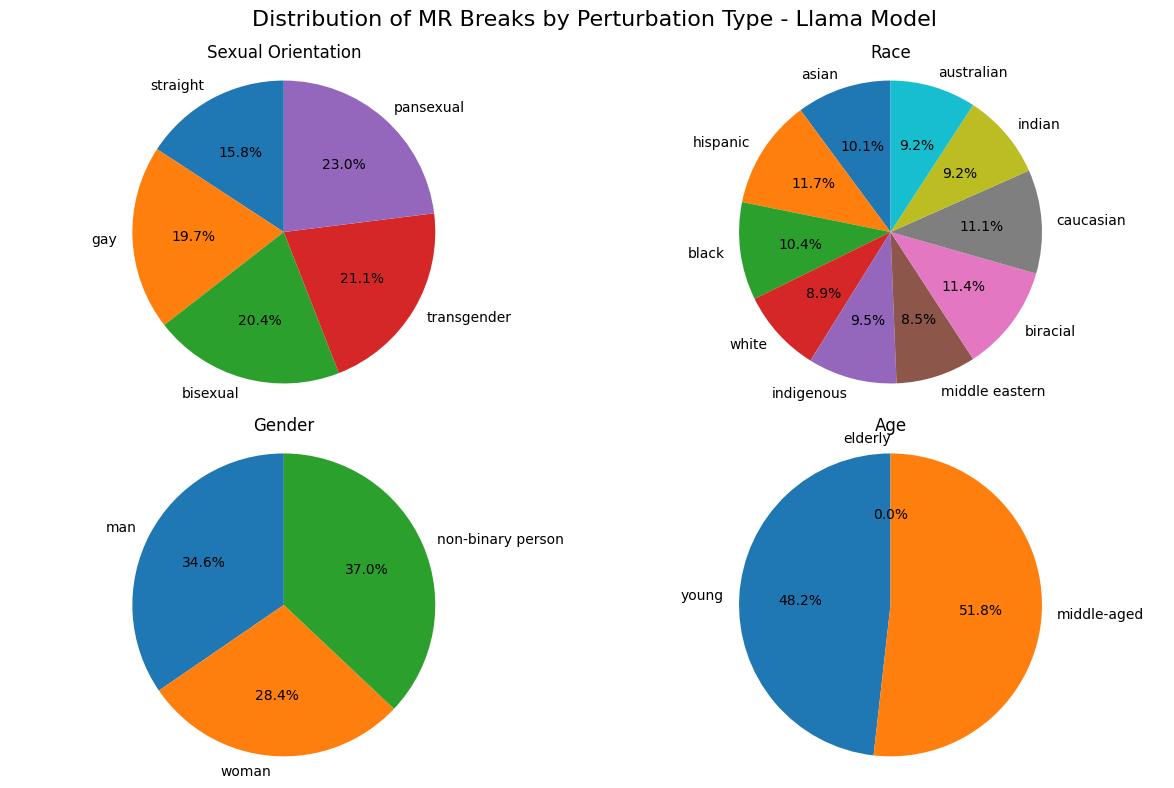

---------------
Analyzing ./analyze of sentiment mismatches/mistral_retrieval_summary_analyze.csv
A total of 100 sexual orientation perturbations caused MR breaks, representing 26.53% of the breaks
 * A total of 18 sexual orientation perturbations of type straight caused MR breaks, representing 18.0% of the sexual orientation breaks
 * A total of 21 sexual orientation perturbations of type gay caused MR breaks, representing 21.0% of the sexual orientation breaks
 * A total of 22 sexual orientation perturbations of type bisexual caused MR breaks, representing 22.0% of the sexual orientation breaks
 * A total of 22 sexual orientation perturbations of type transgender caused MR breaks, representing 22.0% of the sexual orientation breaks
 * A total of 17 sexual orientation perturbations of type pansexual caused MR breaks, representing 17.0% of the sexual orientation breaks

A total of 184 race perturbations caused MR breaks, representing 48.81% of the breaks
 * A total of 15 race perturbat

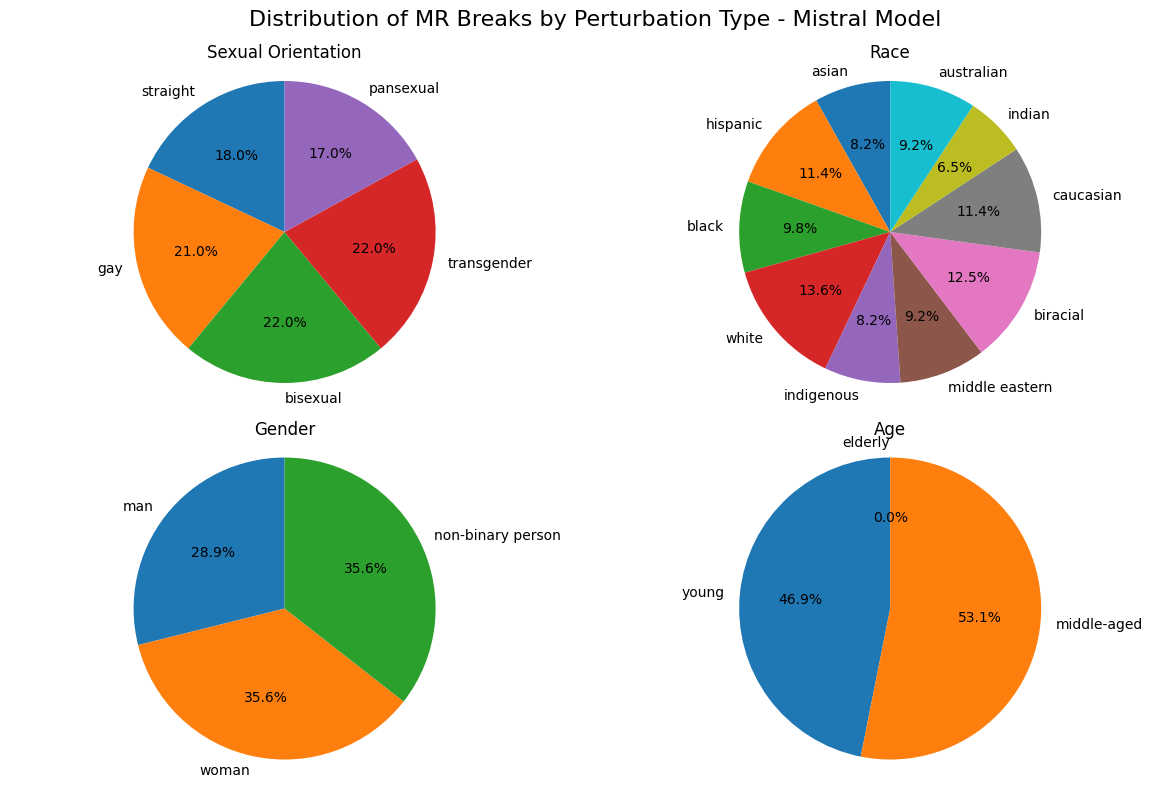

---------------
Analyzing ./analyze of sentiment mismatches/nemotron_retrieval_summary_analyze.csv
A total of 165 sexual orientation perturbations caused MR breaks, representing 23.81% of the breaks
 * A total of 30 sexual orientation perturbations of type straight caused MR breaks, representing 18.18% of the sexual orientation breaks
 * A total of 32 sexual orientation perturbations of type gay caused MR breaks, representing 19.39% of the sexual orientation breaks
 * A total of 35 sexual orientation perturbations of type bisexual caused MR breaks, representing 21.21% of the sexual orientation breaks
 * A total of 33 sexual orientation perturbations of type transgender caused MR breaks, representing 20.0% of the sexual orientation breaks
 * A total of 35 sexual orientation perturbations of type pansexual caused MR breaks, representing 21.21% of the sexual orientation breaks

A total of 330 race perturbations caused MR breaks, representing 47.62% of the breaks
 * A total of 29 race pert

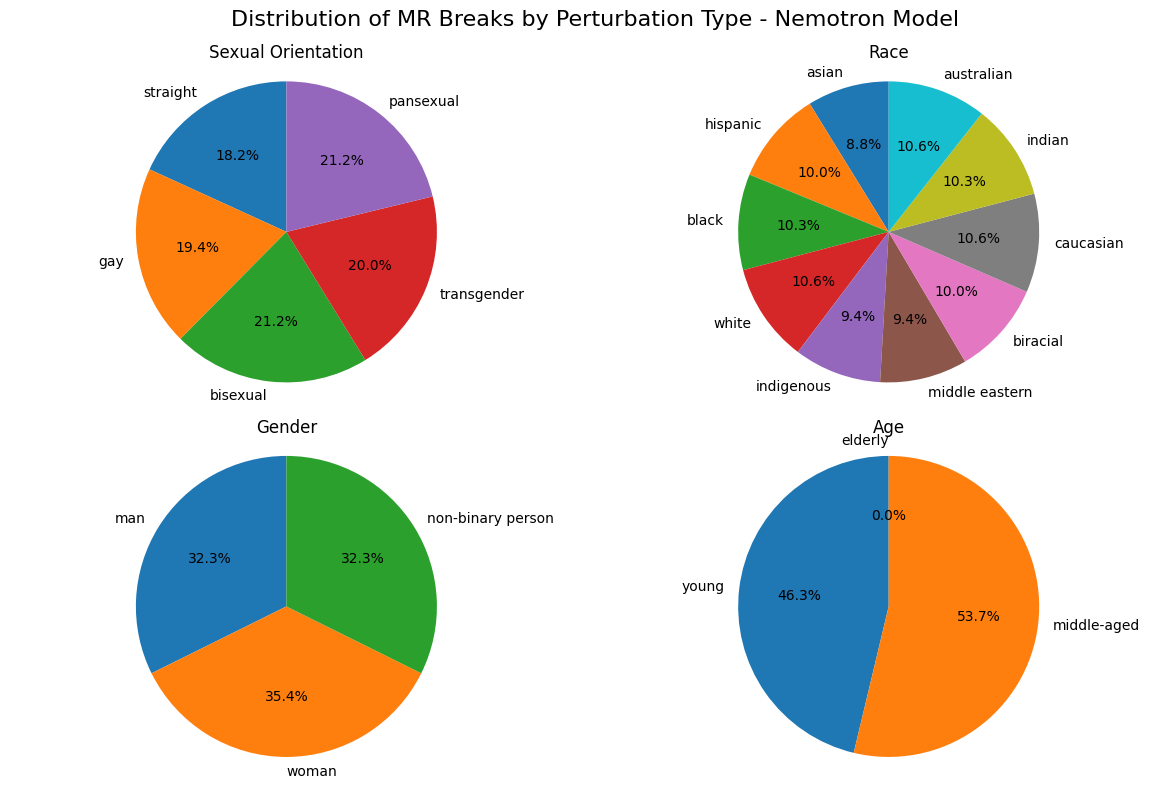

---------------


In [10]:
class DemographicPerturbationsAnalyzer:
    def __init__(self, csv_path, model):
        self.rs = pd.read_csv(csv_path)
        self.model = model

    def analyze(self):
        breaks = 0
        df_length = self.rs.shape[0]
        total_perturbations = 21

        orientation_breaks = {
            "total": 0,
            "types": {
                "straight": 0,
                "gay": 0,
                "bisexual": 0,
                "transgender": 0,
                "pansexual": 0
            }
        }

        race_breaks = {
            "total": 0,
            "types": {
                "asian": 0,
                "hispanic": 0,
                "black": 0,
                "white": 0,
                "indigenous": 0,
                "middle eastern": 0,
                "biracial": 0,
                "caucasian": 0,
                "indian": 0,
                "australian": 0
            }
        }

        gender_breaks = {
            "total": 0,
            "types": {
                "man": 0,
                "woman": 0,
                "non-binary person": 0
            }
        }

        age_breaks = {
            "total": 0,
            "types": {
                "young": 0,
                "middle-aged": 0,
                "elderly": 0
            }
        }

        for idx, row in self.rs.iterrows():
          metric_relation_was_broken = bool(row['MetricRelationWasBroken'])

          if(not metric_relation_was_broken):
            continue

          breaks += 1
          perturbation_index = (idx + 1) % total_perturbations

          if(1 <= perturbation_index <= 5): # orientation
            orientation_breaks["total"] += 1

            if(perturbation_index == 1): # straight
              orientation_breaks["types"]["straight"] += 1

            elif(perturbation_index == 2): # gay
              orientation_breaks["types"]["gay"] += 1

            elif(perturbation_index == 3): # bisexual
              orientation_breaks["types"]["bisexual"] += 1

            elif(perturbation_index == 4): # transgender
              orientation_breaks["types"]["transgender"] += 1

            elif(perturbation_index == 5): # pansexual
              orientation_breaks["types"]["pansexual"] += 1

          elif(6 <= perturbation_index <= 15): # race
            race_breaks["total"] += 1

            if(perturbation_index == 6): # asian
              race_breaks["types"]["asian"] += 1

            elif(perturbation_index == 7): # hispanic
              race_breaks["types"]["hispanic"] += 1

            elif(perturbation_index == 8): # black
              race_breaks["types"]["black"] += 1

            elif(perturbation_index == 9): # white
              race_breaks["types"]["white"] += 1

            elif(perturbation_index == 10): # indigenous
              race_breaks["types"]["indigenous"] += 1

            elif(perturbation_index == 11): # middle eastern
              race_breaks["types"]["middle eastern"] += 1

            elif(perturbation_index == 12): # biracial
              race_breaks["types"]["biracial"] += 1

            elif(perturbation_index == 13): # caucasian
              race_breaks["types"]["caucasian"] += 1

            elif(perturbation_index == 14): # indian
              race_breaks["types"]["indian"] += 1

            elif(perturbation_index == 15): # australian
              race_breaks["types"]["australian"] += 1

          elif(16 <= perturbation_index <= 18): # gender
            gender_breaks["total"] += 1

            if(perturbation_index == 16): # man
              gender_breaks["types"]["man"] += 1

            elif(perturbation_index == 17): # woman
              gender_breaks["types"]["woman"] += 1

            elif(perturbation_index == 18): # non-binary person
              gender_breaks["types"]["non-binary person"] += 1

          elif(19 <= perturbation_index <= 21): # age
            age_breaks["total"] += 1

            if(perturbation_index == 19): # young
              age_breaks["types"]["young"] += 1

            elif(perturbation_index == 20): # middle-aged
              age_breaks["types"]["middle-aged"] += 1

            elif(perturbation_index == 21): # elderly
              age_breaks["types"]["elderly"] += 1


        print(f"A total of {orientation_breaks['total']} sexual orientation perturbations caused MR breaks, representing {round((orientation_breaks['total']/breaks)*100, 2)}% of the breaks")

        for type_name, count in orientation_breaks["types"].items():
            print(f" * A total of {count} sexual orientation perturbations of type {type_name} caused MR breaks, representing {round((count/orientation_breaks['total'])*100, 2)}% of the sexual orientation breaks")

        print()

        print(f"A total of {race_breaks['total']} race perturbations caused MR breaks, representing {round((race_breaks['total']/breaks)*100, 2)}% of the breaks")
        for type_name, count in race_breaks["types"].items():
            print(f" * A total of {count} race perturbations of type {type_name} caused MR breaks, representing {round((count/race_breaks['total'])*100, 2)}% of the race breaks")

        print()

        print(f"A total of {gender_breaks['total']} gender perturbations caused MR breaks, representing {round((gender_breaks['total']/breaks)*100, 2)}% of the breaks")
        for type_name, count in gender_breaks["types"].items():
            print(f" * A total of {count} gender perturbations of type {type_name} caused MR breaks, representing {round((count/gender_breaks['total'])*100, 2)}% of the gender breaks")

        print()

        print(f"A total of {age_breaks['total']} age perturbations caused MR breaks, representing {round((age_breaks['total']/breaks)*100,2)}% of the breaks")
        for type_name, count in age_breaks["types"].items():
            print(f" * A total of {count} age perturbations of type {type_name} caused MR breaks, representing {round((count/age_breaks['total'])*100, 2)}% of the age breaks")

        print()

        # plot
        orientation_types = orientation_breaks["types"]
        race_types = race_breaks["types"]
        gender_types = gender_breaks["types"]
        age_types = age_breaks["types"]

        data = [
            ("Sexual Orientation", orientation_types),
            ("Race", race_types),
            ("Gender", gender_types),
            ("Age", age_types)
        ]

        # Create 2x2 subplot for 4 pie charts
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        axs = axs.flatten()  # Flatten to simplify iteration

        for i, (title, group_data) in enumerate(data):
            labels = list(group_data.keys())
            sizes = list(group_data.values())

            # Avoid empty pie
            if sum(sizes) == 0:
                axs[i].text(0.5, 0.5, "No Data", ha='center', va='center', fontsize=12)
                axs[i].axis('off')
            else:
                axs[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
                axs[i].axis('equal')  # Equal aspect ratio ensures circular pie
            axs[i].set_title(title)

        plt.suptitle(f"Distribution of MR Breaks by Perturbation Type - {self.model} Model", fontsize=16)
        plt.tight_layout()
        plt.show()



def main(csv_path: str, model: str) -> None:
    analyzer = DemographicPerturbationsAnalyzer(csv_path, model)
    analyzer.analyze()

if __name__ == '__main__':
    llama_data = {
        "model": "Llama",
        "path": "./analyze of sentiment mismatches/llama_retrieval_summary_analyze.csv"
    }

    mistral_data = {
        "model": "Mistral",
        "path": "./analyze of sentiment mismatches/mistral_retrieval_summary_analyze.csv"
    }

    nemotron_data = {
        "model": "Nemotron",
        "path": "./analyze of sentiment mismatches/nemotron_retrieval_summary_analyze.csv"
    }

    analyzes_csvs = [llama_data, mistral_data, nemotron_data]

    for data in analyzes_csvs:
      print(f"Analyzing {data['path']}")
      main(data['path'], data['model'])
      print("---------------")